In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **DISCRIMINATOR**

In [2]:
import torch
import torch.nn as nn



#Disriminator CNN BLOCK
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(CNNBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, 4, stride, 1, bias=False, padding_mode="reflect"
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.conv(x)

    
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels*2, 64, kernel_size=4, stride=2, padding=1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
            CNNBlock(64, 128, stride=2),
            CNNBlock(128, 256, stride=2),
            CNNBlock(256, 512, stride=1),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"),
        )
        
        
    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        x = self.initial(x)
        return x

def test():
    x = torch.randn((1, 3, 256, 256))
    y = torch.randn((1, 3, 256, 256))
    model = Discriminator(in_channels=3)
    preds = model(x, y)
    print(model)
    print(preds.shape)
    
    


if __name__ == "__main__":
    test()
    
    

Discriminator(
  (initial): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (1): LeakyReLU(negative_slope=0.2)
    (2): CNNBlock(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (3): CNNBlock(
      (conv): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (4): CNNBlock(
      (conv): Sequential(
        (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=reflect)
        (1): BatchNorm2d(512, eps=1e-05, mom

# **GENERATOR**

In [3]:
#Generetor block(with Conv2d for down steps and Convd2dTranspose for up step)
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
        super(Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode="reflect")
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2),
        )

        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        self.down = down

    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x


class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )
        self.down1 = Block(features, features * 2, down=True, act="leaky", use_dropout=False)
        self.down2 = Block(
            features * 2, features * 4, down=True, act="leaky", use_dropout=False
        )
        self.down3 = Block(
            features * 4, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down4 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down5 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down6 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features * 8, features * 8, 4, 2, 1), nn.ReLU()
        )

        self.up1 = Block(features * 8, features * 8, down=False, act="relu", use_dropout=True)
        self.up2 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up3 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up4 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=False
        )
        self.up5 = Block(
            features * 8 * 2, features * 4, down=False, act="relu", use_dropout=False
        )
        self.up6 = Block(
            features * 4 * 2, features * 2, down=False, act="relu", use_dropout=False
        )
        self.up7 = Block(features * 2 * 2, features, down=False, act="relu", use_dropout=False)
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features * 2, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        up1 = self.up1(bottleneck)
        #skip conncetions betwwen down and up portions
        up2 = self.up2(torch.cat([up1, d7], 1))
        up3 = self.up3(torch.cat([up2, d6], 1))
        up4 = self.up4(torch.cat([up3, d5], 1))
        up5 = self.up5(torch.cat([up4, d4], 1))
        up6 = self.up6(torch.cat([up5, d3], 1))
        up7 = self.up7(torch.cat([up6, d2], 1))
        return self.final_up(torch.cat([up7, d1], 1))


def test():
    x = torch.randn((1, 3, 256, 256))
    model = Generator(in_channels=3, features=64)
    preds = model(x)
    print(model)
    print(preds.shape)


if __name__ == "__main__":
    test()

Generator(
  (initial_down): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (down1): Block(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (down2): Block(
    (conv): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (down3): Block(
    (conv): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, pa

In [4]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.transforms import v2

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TRAIN_DIR = "/kaggle/input/pix2pix-dataset/maps/maps/train"
VAL_DIR = "/kaggle/input/pix2pix-dataset/maps/maps/val"
LEARNING_RATE = 2e-4
BATCH_SIZE = 16
NUM_WORKERS = 2
IMAGE_SIZE = 256
CHANNELS_IMG = 3
L1_LAMBDA = 100
NUM_EPOCHS = 200
LOAD_MODEL = True
SAVE_MODEL = True
CHECKPOINT_DISC = "/kaggle/input/models/disc.pth.tar"
CHECKPOINT_GEN = "/kaggle/input/models/gen.pth.tar"


mean=[0.5, 0.5, 0.5]
std=[0.5, 0.5, 0.5]

transform_input = v2.Compose([
    v2.ToPILImage(),
    v2.Resize((256, 256)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ColorJitter(brightness = 2),
    v2.ToTensor(),
    v2.Normalize(mean, std),
])

transform_target = v2.Compose([
    v2.ToPILImage(),
    v2.Resize((256, 256)),
    v2.ToTensor(),
    v2.Normalize(mean, std),
])

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning

# **LOAD DATASET**

In [5]:
import numpy as np
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image


class MapDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.list_files = os.listdir(self.root_dir)

    def __len__(self):
        return len(self.list_files)

    def __getitem__(self, index):
        img_file = self.list_files[index]
        img_path = os.path.join(self.root_dir, img_file)
        image = np.array(Image.open(img_path))
        input_image = image[:, :600, :]
        target_image = image[:, 600:, :]
        input_image = transform_input(input_image)
        target_image = transform_target(target_image)

        return input_image, target_image


if __name__ == "__main__":
    dataset = MapDataset("/kaggle/input/pix2pix-dataset/maps/maps/train")
    loader = DataLoader(dataset, batch_size=5)
    for x, y in loader:
        save_image(x, "x.png")
        save_image(y, "y.png")
        import sys

        sys.exit()

SystemExit: 

/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# **TRAIN AND VALIDATION**

In [6]:
import torch
from torchvision.utils import save_image

def save_some_examples(gen, val_loader, epoch, folder):
    x, y = next(iter(val_loader))
    x, y = x.to(DEVICE), y.to(DEVICE)
    gen.eval()
    with torch.no_grad():
        y_fake = gen(x)
        y_fake = y_fake * 0.5 + 0.5  # remove normalization#
        save_image(y_fake, folder + f"/y_gen_{epoch}.png")
        save_image(x * 0.5 + 0.5, folder + f"/input_{epoch}.png")
        if epoch == 1:
            save_image(y * 0.5 + 0.5, folder + f"/label_{epoch}.png")
    gen.train()


def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

=> Loading checkpoint
=> Loading checkpoint


100%|██████████| 69/69 [00:22<00:00,  3.03it/s]


Train loss for generator:  13.748773783662893
Train loss for discriminator:  0.4282687049712578


100%|██████████| 1098/1098 [00:44<00:00, 24.84it/s]


Validation loss for generator:  192.33672016609344
Validation loss for discriminator:  12.715529728022647
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  13.490438043636127
Train loss for discriminator:  0.32671720159314843


100%|██████████| 1098/1098 [00:43<00:00, 25.07it/s]


Validation loss for generator:  169.89325257598378
Validation loss for discriminator:  13.961989771472952


100%|██████████| 69/69 [00:23<00:00,  3.00it/s]


Train loss for generator:  13.78754832970835
Train loss for discriminator:  0.3363853588591527


100%|██████████| 1098/1098 [00:43<00:00, 24.96it/s]


Validation loss for generator:  198.40865095239303
Validation loss for discriminator:  20.566916475747668


100%|██████████| 69/69 [00:22<00:00,  3.03it/s]


Train loss for generator:  13.48890864239992
Train loss for discriminator:  0.3338700852689952


100%|██████████| 1098/1098 [00:44<00:00, 24.77it/s]


Validation loss for generator:  217.7421873506084
Validation loss for discriminator:  21.179471226989246


100%|██████████| 69/69 [00:22<00:00,  3.03it/s]


Train loss for generator:  13.495908946016408
Train loss for discriminator:  0.35713537896636627


100%|██████████| 1098/1098 [00:43<00:00, 25.14it/s]


Validation loss for generator:  194.47296726247652
Validation loss for discriminator:  11.769650845362623


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  13.355744090393513
Train loss for discriminator:  0.37209461988323794


100%|██████████| 1098/1098 [00:43<00:00, 25.23it/s]


Validation loss for generator:  188.8958265342782
Validation loss for discriminator:  14.734710507054146
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:22<00:00,  3.00it/s]


Train loss for generator:  15.005620385608534
Train loss for discriminator:  0.18879348879856786


100%|██████████| 1098/1098 [00:44<00:00, 24.86it/s]


Validation loss for generator:  175.12354347354076
Validation loss for discriminator:  17.75351423144558


100%|██████████| 69/69 [00:22<00:00,  3.03it/s]


Train loss for generator:  16.17206751691164
Train loss for discriminator:  0.0106764602284525


100%|██████████| 1098/1098 [00:44<00:00, 24.86it/s]


Validation loss for generator:  185.8644650360274
Validation loss for discriminator:  23.056712310822284


100%|██████████| 69/69 [00:22<00:00,  3.03it/s]


Train loss for generator:  15.972682841502838
Train loss for discriminator:  0.21020977096428184


100%|██████████| 1098/1098 [00:45<00:00, 24.27it/s]


Validation loss for generator:  271.4767150531484
Validation loss for discriminator:  29.352445708163668


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  15.823705227705684
Train loss for discriminator:  0.31042442682885774


100%|██████████| 1098/1098 [00:45<00:00, 24.08it/s]


Validation loss for generator:  203.39401377137676
Validation loss for discriminator:  12.125879451442502


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  15.289611356971907
Train loss for discriminator:  0.2774929141584974


100%|██████████| 1098/1098 [00:45<00:00, 24.08it/s]


Validation loss for generator:  271.5368881885688
Validation loss for discriminator:  13.543936452796116
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  14.412949736100915
Train loss for discriminator:  0.297315749156214


100%|██████████| 1098/1098 [00:45<00:00, 24.04it/s]


Validation loss for generator:  194.69669350379152
Validation loss for discriminator:  15.414702425237563


100%|██████████| 69/69 [00:23<00:00,  2.99it/s]


Train loss for generator:  16.272825714445464
Train loss for discriminator:  0.09099582698277749


100%|██████████| 1098/1098 [00:45<00:00, 24.03it/s]


Validation loss for generator:  169.43774658647826
Validation loss for discriminator:  13.975154565440285


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  17.281124476968806
Train loss for discriminator:  0.04609617417895772


100%|██████████| 1098/1098 [00:45<00:00, 24.01it/s]


Validation loss for generator:  193.48701320710728
Validation loss for discriminator:  12.642572570151101


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  15.778385649632364
Train loss for discriminator:  0.22822867040216488


100%|██████████| 1098/1098 [00:45<00:00, 24.09it/s]


Validation loss for generator:  200.58068545398817
Validation loss for discriminator:  11.740748026766195


100%|██████████| 69/69 [00:22<00:00,  3.00it/s]


Train loss for generator:  14.388141994058651
Train loss for discriminator:  0.32228488143343126


100%|██████████| 1098/1098 [00:45<00:00, 24.05it/s]


Validation loss for generator:  178.23449366209937
Validation loss for discriminator:  12.072642206494274
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:23<00:00,  2.99it/s]


Train loss for generator:  14.265836200574888
Train loss for discriminator:  0.3303968735637456


100%|██████████| 1098/1098 [00:45<00:00, 24.14it/s]


Validation loss for generator:  195.5706336155181
Validation loss for discriminator:  12.34302946691739


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  14.842326895163877
Train loss for discriminator:  0.3311900922851841


100%|██████████| 1098/1098 [00:45<00:00, 24.11it/s]


Validation loss for generator:  180.21760143217494
Validation loss for discriminator:  12.762471393157876


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  13.899017528895914
Train loss for discriminator:  0.34900060818143136


100%|██████████| 1098/1098 [00:45<00:00, 24.07it/s]


Validation loss for generator:  188.03634362490016
Validation loss for discriminator:  17.57008130780552


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  14.158109511772212
Train loss for discriminator:  0.29724801641746157


100%|██████████| 1098/1098 [00:45<00:00, 24.30it/s]


Validation loss for generator:  198.3427177144313
Validation loss for discriminator:  14.550093932229965


100%|██████████| 69/69 [00:22<00:00,  3.00it/s]


Train loss for generator:  14.931642950016217
Train loss for discriminator:  0.3218792488213873


100%|██████████| 1098/1098 [00:45<00:00, 23.99it/s]


Validation loss for generator:  199.21472996223602
Validation loss for discriminator:  18.518407532860454
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  14.242542489601748
Train loss for discriminator:  0.3006422780726078


100%|██████████| 1098/1098 [00:45<00:00, 24.10it/s]


Validation loss for generator:  211.03300683485355
Validation loss for discriminator:  14.193011848870087


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  13.760337244855226
Train loss for discriminator:  0.38103654545589083


100%|██████████| 1098/1098 [00:45<00:00, 24.11it/s]


Validation loss for generator:  236.13451261815695
Validation loss for discriminator:  17.646263780489644


100%|██████████| 69/69 [00:23<00:00,  2.99it/s]


Train loss for generator:  14.311606831794238
Train loss for discriminator:  0.2688401938300498


100%|██████████| 1098/1098 [00:46<00:00, 23.65it/s]


Validation loss for generator:  192.1778522970898
Validation loss for discriminator:  18.507763419646384


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  14.687675559607735
Train loss for discriminator:  0.21394356601212147


100%|██████████| 1098/1098 [00:46<00:00, 23.63it/s]


Validation loss for generator:  219.83598515939624
Validation loss for discriminator:  13.739743705655707


100%|██████████| 69/69 [00:23<00:00,  2.99it/s]


Train loss for generator:  13.945379535647204
Train loss for discriminator:  0.3249091031777598


100%|██████████| 1098/1098 [00:46<00:00, 23.56it/s]


Validation loss for generator:  180.5071336298041
Validation loss for discriminator:  10.881558652784003
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  13.872717154287074
Train loss for discriminator:  0.40661633058186


100%|██████████| 1098/1098 [00:46<00:00, 23.84it/s]


Validation loss for generator:  176.3624404045619
Validation loss for discriminator:  11.769402483121945


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  13.866688275859303
Train loss for discriminator:  0.30248100011453144


100%|██████████| 1098/1098 [00:46<00:00, 23.75it/s]


Validation loss for generator:  180.15497610998935
Validation loss for discriminator:  12.234843378727119


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  13.734377798372812
Train loss for discriminator:  0.31188856576481006


100%|██████████| 1098/1098 [00:46<00:00, 23.72it/s]


Validation loss for generator:  177.67677446445265
Validation loss for discriminator:  12.063230829812138


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  14.103939362686045
Train loss for discriminator:  0.34840818423859393


100%|██████████| 1098/1098 [00:46<00:00, 23.83it/s]


Validation loss for generator:  187.37746414851622
Validation loss for discriminator:  13.308432068329692


100%|██████████| 69/69 [00:22<00:00,  3.00it/s]


Train loss for generator:  14.25317029187279
Train loss for discriminator:  0.2726495691242009


100%|██████████| 1098/1098 [00:46<00:00, 23.79it/s]


Validation loss for generator:  200.09195447966917
Validation loss for discriminator:  11.044138203118885
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:22<00:00,  3.00it/s]


Train loss for generator:  14.305079898695006
Train loss for discriminator:  0.28059012698431085


100%|██████████| 1098/1098 [00:46<00:00, 23.82it/s]


Validation loss for generator:  243.76143652146413
Validation loss for discriminator:  66.51902907054348


100%|██████████| 69/69 [00:23<00:00,  2.99it/s]


Train loss for generator:  15.017023504215436
Train loss for discriminator:  0.20848900397872402


100%|██████████| 1098/1098 [00:46<00:00, 23.64it/s]


Validation loss for generator:  189.6555801836302
Validation loss for discriminator:  11.912101894562795


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  14.207284273022283
Train loss for discriminator:  0.2518836383293145


100%|██████████| 1098/1098 [00:46<00:00, 23.48it/s]


Validation loss for generator:  186.1208905843655
Validation loss for discriminator:  11.494333467414036


100%|██████████| 69/69 [00:22<00:00,  3.00it/s]


Train loss for generator:  14.193162138444665
Train loss for discriminator:  0.27531619027365734


100%|██████████| 1098/1098 [00:46<00:00, 23.65it/s]


Validation loss for generator:  194.25124080845566
Validation loss for discriminator:  15.998623477848067


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  15.681276975757013
Train loss for discriminator:  0.14799724301717576


100%|██████████| 1098/1098 [00:46<00:00, 23.78it/s]


Validation loss for generator:  235.449875862872
Validation loss for discriminator:  14.366320246121488
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:22<00:00,  3.00it/s]


Train loss for generator:  15.028312655260963
Train loss for discriminator:  0.1815810342230936


100%|██████████| 1098/1098 [00:46<00:00, 23.81it/s]


Validation loss for generator:  213.8765360827003
Validation loss for discriminator:  27.418195642843056


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  14.370057990081119
Train loss for discriminator:  0.3217044523271331


100%|██████████| 1098/1098 [00:46<00:00, 23.72it/s]


Validation loss for generator:  217.84445486433518
Validation loss for discriminator:  20.384013439571053


100%|██████████| 69/69 [00:23<00:00,  3.00it/s]


Train loss for generator:  13.918095345044659
Train loss for discriminator:  0.24385245579437617


100%|██████████| 1098/1098 [00:46<00:00, 23.62it/s]


Validation loss for generator:  183.6914595028959
Validation loss for discriminator:  14.221043469910196


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  14.215964978628785
Train loss for discriminator:  0.17167020926292795


100%|██████████| 1098/1098 [00:45<00:00, 24.39it/s]


Validation loss for generator:  216.01260511471273
Validation loss for discriminator:  22.160126842870522


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  14.347272162889912
Train loss for discriminator:  0.1915048686855466


100%|██████████| 1098/1098 [00:44<00:00, 24.44it/s]


Validation loss for generator:  196.16967453808948
Validation loss for discriminator:  16.955894465437787
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:22<00:00,  3.03it/s]


Train loss for generator:  14.684800377727425
Train loss for discriminator:  0.1875088369460219


100%|██████████| 1098/1098 [00:43<00:00, 25.11it/s]


Validation loss for generator:  186.4430344100424
Validation loss for discriminator:  13.722005758997739


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  14.898762334002196
Train loss for discriminator:  0.24994227692593624


100%|██████████| 1098/1098 [00:43<00:00, 25.10it/s]


Validation loss for generator:  202.50981816220587
Validation loss for discriminator:  23.07528244037663


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  14.590182046820647
Train loss for discriminator:  0.20830049006825815


100%|██████████| 1098/1098 [00:44<00:00, 24.72it/s]


Validation loss for generator:  189.601606997853
Validation loss for discriminator:  12.548985582014685


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  14.978688539379705
Train loss for discriminator:  0.20725615605385633


100%|██████████| 1098/1098 [00:45<00:00, 24.35it/s]


Validation loss for generator:  197.3927582356882
Validation loss for discriminator:  17.492300811578232


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  14.822684531664326
Train loss for discriminator:  0.2296304621183089


100%|██████████| 1098/1098 [00:43<00:00, 25.23it/s]


Validation loss for generator:  229.48289950428114
Validation loss for discriminator:  14.282310674316461
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:22<00:00,  3.03it/s]


Train loss for generator:  14.634639809601499
Train loss for discriminator:  0.29939176903588927


100%|██████████| 1098/1098 [00:43<00:00, 25.25it/s]


Validation loss for generator:  234.38807912385312
Validation loss for discriminator:  12.37797188150861


100%|██████████| 69/69 [00:22<00:00,  3.03it/s]


Train loss for generator:  14.660664690672046
Train loss for discriminator:  0.37827833654889226


100%|██████████| 1098/1098 [00:43<00:00, 25.00it/s]


Validation loss for generator:  205.34276928232885
Validation loss for discriminator:  13.134203434859034


100%|██████████| 69/69 [00:22<00:00,  3.03it/s]


Train loss for generator:  14.104126937197943
Train loss for discriminator:  0.33434892853681186


100%|██████████| 1098/1098 [00:43<00:00, 25.07it/s]


Validation loss for generator:  200.78427011979733
Validation loss for discriminator:  12.362365300755249


100%|██████████| 69/69 [00:22<00:00,  3.03it/s]


Train loss for generator:  14.009203889944258
Train loss for discriminator:  0.3615661955771655


100%|██████████| 1098/1098 [00:43<00:00, 25.16it/s]


Validation loss for generator:  180.7729892904424
Validation loss for discriminator:  12.959958569382492


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  14.108316797409614
Train loss for discriminator:  0.2922907954584943


100%|██████████| 1098/1098 [00:44<00:00, 24.77it/s]


Validation loss for generator:  227.91558654104207
Validation loss for discriminator:  13.27921694223998
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  14.574669385478444
Train loss for discriminator:  0.2943362062049173


100%|██████████| 1098/1098 [00:43<00:00, 25.03it/s]


Validation loss for generator:  257.8602208309486
Validation loss for discriminator:  17.775218563218804


100%|██████████| 69/69 [00:22<00:00,  3.03it/s]


Train loss for generator:  14.038589602839338
Train loss for discriminator:  0.3493744479696246


100%|██████████| 1098/1098 [00:44<00:00, 24.66it/s]


Validation loss for generator:  163.32960070069805
Validation loss for discriminator:  13.822897630093962


100%|██████████| 69/69 [00:22<00:00,  3.04it/s]


Train loss for generator:  14.098772605840306
Train loss for discriminator:  0.2923867252186267


100%|██████████| 1098/1098 [00:43<00:00, 25.09it/s]


Validation loss for generator:  259.790427195787
Validation loss for discriminator:  13.231114409226103


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  13.661741911059748
Train loss for discriminator:  0.3049142008280232


100%|██████████| 1098/1098 [00:43<00:00, 25.16it/s]


Validation loss for generator:  179.71914026646016
Validation loss for discriminator:  15.351596366729458


100%|██████████| 69/69 [00:22<00:00,  3.03it/s]


Train loss for generator:  13.865393464582679
Train loss for discriminator:  0.23215896478534614


100%|██████████| 1098/1098 [00:43<00:00, 25.34it/s]


Validation loss for generator:  254.52345353354087
Validation loss for discriminator:  14.313519498689578
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  14.524211702555636
Train loss for discriminator:  0.2856261582270156


100%|██████████| 1098/1098 [00:43<00:00, 25.06it/s]


Validation loss for generator:  222.5526322953688
Validation loss for discriminator:  24.103213181369725


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  14.09927834559531
Train loss for discriminator:  0.2435128132465982


100%|██████████| 1098/1098 [00:43<00:00, 25.04it/s]


Validation loss for generator:  234.87766538595676
Validation loss for discriminator:  11.991310222552773


100%|██████████| 69/69 [00:22<00:00,  3.03it/s]


Train loss for generator:  13.931284354550995
Train loss for discriminator:  0.28125588769895316


100%|██████████| 1098/1098 [00:43<00:00, 25.34it/s]


Validation loss for generator:  167.80054085806202
Validation loss for discriminator:  12.311529664611122


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  14.046706610352453
Train loss for discriminator:  0.28998041087693543


100%|██████████| 1098/1098 [00:44<00:00, 24.92it/s]


Validation loss for generator:  205.97874540665978
Validation loss for discriminator:  12.624731729156549


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  14.139774531343557
Train loss for discriminator:  0.2638569741788572


100%|██████████| 1098/1098 [00:44<00:00, 24.87it/s]


Validation loss for generator:  224.25576325713612
Validation loss for discriminator:  23.261303554032885
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  14.26745172486688
Train loss for discriminator:  0.2689380178051273


100%|██████████| 1098/1098 [00:44<00:00, 24.85it/s]


Validation loss for generator:  178.3965352932178
Validation loss for discriminator:  11.100813849593338


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  13.790424875969434
Train loss for discriminator:  0.26082784057098585


100%|██████████| 1098/1098 [00:44<00:00, 24.92it/s]


Validation loss for generator:  211.75821568362267
Validation loss for discriminator:  15.624204543553198


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  14.60578234874419
Train loss for discriminator:  0.2660115287251716


100%|██████████| 1098/1098 [00:44<00:00, 24.43it/s]


Validation loss for generator:  183.712080561181
Validation loss for discriminator:  13.256182806305112


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  13.717696280375014
Train loss for discriminator:  0.2577048785930132


100%|██████████| 1098/1098 [00:44<00:00, 24.44it/s]


Validation loss for generator:  178.84457461386648
Validation loss for discriminator:  11.232241032553501


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  13.886180961219063
Train loss for discriminator:  0.295283751766177


100%|██████████| 1098/1098 [00:45<00:00, 24.03it/s]


Validation loss for generator:  244.67198306224384
Validation loss for discriminator:  16.212784713300415
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:23<00:00,  3.00it/s]


Train loss for generator:  13.915387244120131
Train loss for discriminator:  0.28349388341834075


100%|██████████| 1098/1098 [00:46<00:00, 23.87it/s]


Validation loss for generator:  188.92224323988395
Validation loss for discriminator:  14.286993439297424


100%|██████████| 69/69 [00:22<00:00,  3.00it/s]


Train loss for generator:  13.736801634739786
Train loss for discriminator:  0.32363678471450386


100%|██████████| 1098/1098 [00:45<00:00, 24.25it/s]


Validation loss for generator:  168.73010408856612
Validation loss for discriminator:  12.248955024178997


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  13.990221691827704
Train loss for discriminator:  0.24848567286547082


100%|██████████| 1098/1098 [00:45<00:00, 24.10it/s]


Validation loss for generator:  177.58647936072288
Validation loss for discriminator:  12.62221770859807


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  13.59030731925129
Train loss for discriminator:  0.2664223305717872


100%|██████████| 1098/1098 [00:45<00:00, 24.15it/s]


Validation loss for generator:  238.93874147550656
Validation loss for discriminator:  11.266691727933553


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  13.68960439027661
Train loss for discriminator:  0.30018215751560934


100%|██████████| 1098/1098 [00:45<00:00, 24.30it/s]


Validation loss for generator:  221.73474607485022
Validation loss for discriminator:  11.895755941099157
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  13.737242246196217
Train loss for discriminator:  0.34504545550711835


100%|██████████| 1098/1098 [00:45<00:00, 24.08it/s]


Validation loss for generator:  170.06729668997676
Validation loss for discriminator:  11.455194249179193


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  13.818255375771628
Train loss for discriminator:  0.3977484479002709


100%|██████████| 1098/1098 [00:45<00:00, 23.89it/s]


Validation loss for generator:  227.42270404002704
Validation loss for discriminator:  18.160064701174125


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  13.889137504744705
Train loss for discriminator:  0.2500946426587383


100%|██████████| 1098/1098 [00:45<00:00, 24.29it/s]


Validation loss for generator:  169.6309494303441
Validation loss for discriminator:  12.165941983624235


100%|██████████| 69/69 [00:23<00:00,  3.00it/s]


Train loss for generator:  13.573822522685475
Train loss for discriminator:  0.24442824917118045


100%|██████████| 1098/1098 [00:45<00:00, 24.33it/s]


Validation loss for generator:  184.65516375626805
Validation loss for discriminator:  10.693558786084743


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  14.31338034581094
Train loss for discriminator:  0.26785195821447527


100%|██████████| 1098/1098 [00:45<00:00, 24.05it/s]


Validation loss for generator:  206.71334321207905
Validation loss for discriminator:  45.15466034347242
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  14.69562948185162
Train loss for discriminator:  0.2406049468656526


100%|██████████| 1098/1098 [00:45<00:00, 23.95it/s]


Validation loss for generator:  194.55866674690733
Validation loss for discriminator:  17.402256182199835


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  14.588185247713632
Train loss for discriminator:  0.11111003016359615


100%|██████████| 1098/1098 [00:45<00:00, 24.11it/s]


Validation loss for generator:  192.69545109024466
Validation loss for discriminator:  14.574861057469102


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  14.421778880766709
Train loss for discriminator:  0.10330074054807642


100%|██████████| 1098/1098 [00:45<00:00, 24.14it/s]


Validation loss for generator:  194.43869278079174
Validation loss for discriminator:  13.366594878267938


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  14.83103779980736
Train loss for discriminator:  0.14813236794332518


100%|██████████| 1098/1098 [00:45<00:00, 24.38it/s]


Validation loss for generator:  169.23773105114103
Validation loss for discriminator:  18.17929672456613


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  14.427697327885314
Train loss for discriminator:  0.1726757348345144


100%|██████████| 1098/1098 [00:45<00:00, 24.33it/s]


Validation loss for generator:  194.01095040812953
Validation loss for discriminator:  14.123015729456
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  14.88899393847389
Train loss for discriminator:  0.18136977790480982


100%|██████████| 1098/1098 [00:45<00:00, 23.99it/s]


Validation loss for generator:  192.67343298073024
Validation loss for discriminator:  12.3202864450618


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  14.254834307371265
Train loss for discriminator:  0.20616750614921542


100%|██████████| 1098/1098 [00:45<00:00, 24.30it/s]


Validation loss for generator:  180.0908819799649
Validation loss for discriminator:  11.164848733035159


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  14.195702239544723
Train loss for discriminator:  0.22856961555071992


100%|██████████| 1098/1098 [00:44<00:00, 24.41it/s]


Validation loss for generator:  192.47981943849658
Validation loss for discriminator:  17.626461384292075


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  14.455957635475771
Train loss for discriminator:  0.16275153673478288


100%|██████████| 1098/1098 [00:49<00:00, 22.05it/s]


Validation loss for generator:  255.14534395075452
Validation loss for discriminator:  35.42062665508527


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  14.28547069800161
Train loss for discriminator:  0.23257497642325223


100%|██████████| 1098/1098 [00:45<00:00, 24.34it/s]


Validation loss for generator:  212.86048804389105
Validation loss for discriminator:  15.407129781493724
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  13.946755987014214
Train loss for discriminator:  0.2528864783200904


100%|██████████| 1098/1098 [00:43<00:00, 25.01it/s]


Validation loss for generator:  196.84639209128903
Validation loss for discriminator:  13.308247358638297


100%|██████████| 69/69 [00:22<00:00,  3.03it/s]


Train loss for generator:  14.163933412872092
Train loss for discriminator:  0.1785861605601589


100%|██████████| 1098/1098 [00:44<00:00, 24.86it/s]


Validation loss for generator:  228.23488839293654
Validation loss for discriminator:  11.971532327447


100%|██████████| 69/69 [00:22<00:00,  3.04it/s]


Train loss for generator:  14.774969643920008
Train loss for discriminator:  0.21234938396263298


100%|██████████| 1098/1098 [00:44<00:00, 24.91it/s]


Validation loss for generator:  184.83473124964425
Validation loss for discriminator:  14.064243992712546


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  13.927788281962819
Train loss for discriminator:  0.18123095449957535


100%|██████████| 1098/1098 [00:44<00:00, 24.69it/s]


Validation loss for generator:  235.69659058339826
Validation loss for discriminator:  31.063635747072258


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  14.36397989648972
Train loss for discriminator:  0.17645257798424602


100%|██████████| 1098/1098 [00:44<00:00, 24.69it/s]


Validation loss for generator:  185.88999941570512
Validation loss for discriminator:  22.72852397551302
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  14.0961256375278
Train loss for discriminator:  0.2155163538281935


100%|██████████| 1098/1098 [00:44<00:00, 24.59it/s]


Validation loss for generator:  268.93725567524115
Validation loss for discriminator:  52.671397872744144


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  14.557135421864308
Train loss for discriminator:  0.1815806815305548


100%|██████████| 1098/1098 [00:44<00:00, 24.49it/s]


Validation loss for generator:  192.1495496440672
Validation loss for discriminator:  14.984828915535209


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  13.883952008546704
Train loss for discriminator:  0.18795894787911951


100%|██████████| 1098/1098 [00:45<00:00, 24.19it/s]


Validation loss for generator:  220.78789739139745
Validation loss for discriminator:  14.523875174843766


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  13.918058297929973
Train loss for discriminator:  0.24494164823180567


100%|██████████| 1098/1098 [00:45<00:00, 23.99it/s]


Validation loss for generator:  179.68069054303055
Validation loss for discriminator:  13.154203648992793


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  13.862709769367301
Train loss for discriminator:  0.2057296316662844


100%|██████████| 1098/1098 [00:45<00:00, 24.09it/s]


Validation loss for generator:  201.87149177787518
Validation loss for discriminator:  23.493339424250557
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  15.354901487809899
Train loss for discriminator:  0.32821414300179397


100%|██████████| 1098/1098 [00:45<00:00, 24.06it/s]


Validation loss for generator:  226.50631359496404
Validation loss for discriminator:  36.8834791235585


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  15.06535754238602
Train loss for discriminator:  0.2834848352660337


100%|██████████| 1098/1098 [00:45<00:00, 24.17it/s]


Validation loss for generator:  287.38129640103256
Validation loss for discriminator:  23.415464012566378


100%|██████████| 69/69 [00:22<00:00,  3.00it/s]


Train loss for generator:  16.12944041899521
Train loss for discriminator:  0.10604710659406481


100%|██████████| 1098/1098 [00:44<00:00, 24.43it/s]


Validation loss for generator:  181.08484944619767
Validation loss for discriminator:  18.40963332900584


100%|██████████| 69/69 [00:23<00:00,  3.00it/s]


Train loss for generator:  14.34763128740074
Train loss for discriminator:  0.2045411668228407


100%|██████████| 1098/1098 [00:45<00:00, 24.37it/s]


Validation loss for generator:  286.45918611967716
Validation loss for discriminator:  17.039518938472796


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  14.3601114036393
Train loss for discriminator:  0.1759030698751011


100%|██████████| 1098/1098 [00:44<00:00, 24.47it/s]


Validation loss for generator:  195.71061296932032
Validation loss for discriminator:  12.160381282830716
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  14.476499098060774
Train loss for discriminator:  0.15722209474167032


100%|██████████| 1098/1098 [00:44<00:00, 24.45it/s]


Validation loss for generator:  180.87399792280354
Validation loss for discriminator:  19.042424434738297


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  14.592369970614023
Train loss for discriminator:  0.07853122168376933


100%|██████████| 1098/1098 [00:44<00:00, 24.50it/s]


Validation loss for generator:  205.63578249196536
Validation loss for discriminator:  12.745728983470869


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  14.24140271653224
Train loss for discriminator:  0.12153077024939286


100%|██████████| 1098/1098 [00:45<00:00, 24.34it/s]


Validation loss for generator:  254.86789274997398
Validation loss for discriminator:  14.268119790297822


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  14.197191948438213
Train loss for discriminator:  0.20929465475526168


100%|██████████| 1098/1098 [00:45<00:00, 24.23it/s]


Validation loss for generator:  229.85858790079752
Validation loss for discriminator:  13.79975820304266


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  13.620463768061061
Train loss for discriminator:  0.36203020234612654


100%|██████████| 1098/1098 [00:45<00:00, 24.17it/s]


Validation loss for generator:  238.13052740253386
Validation loss for discriminator:  19.891807463216868
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  13.533030739665902
Train loss for discriminator:  0.3175879096897849


100%|██████████| 1098/1098 [00:45<00:00, 24.30it/s]


Validation loss for generator:  191.71031243162727
Validation loss for discriminator:  15.441789299195364


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  14.092241092319906
Train loss for discriminator:  0.25927721246750685


100%|██████████| 1098/1098 [00:45<00:00, 24.35it/s]


Validation loss for generator:  248.1508637933783
Validation loss for discriminator:  23.172894262876667


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  13.57676180261765
Train loss for discriminator:  0.253322534806972


100%|██████████| 1098/1098 [00:45<00:00, 24.21it/s]


Validation loss for generator:  196.18717477100142
Validation loss for discriminator:  16.069770647528394


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  13.231339099633432
Train loss for discriminator:  0.27998218070851627


100%|██████████| 1098/1098 [00:44<00:00, 24.42it/s]


Validation loss for generator:  185.21449600803396
Validation loss for discriminator:  10.9017845385713


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  13.667626986538407
Train loss for discriminator:  0.2531323096286641


100%|██████████| 1098/1098 [00:45<00:00, 24.39it/s]


Validation loss for generator:  246.10688834893898
Validation loss for discriminator:  18.166295783333005
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  14.169313876298222
Train loss for discriminator:  0.22590576805663806


100%|██████████| 1098/1098 [00:45<00:00, 24.09it/s]


Validation loss for generator:  180.52473621333667
Validation loss for discriminator:  12.779071892762662


100%|██████████| 69/69 [00:22<00:00,  3.03it/s]


Train loss for generator:  13.520714711098776
Train loss for discriminator:  0.29202763059169706


100%|██████████| 1098/1098 [00:45<00:00, 24.15it/s]


Validation loss for generator:  235.09383636224464
Validation loss for discriminator:  40.51324366350643


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  14.658128724481067
Train loss for discriminator:  0.3450748576667078


100%|██████████| 1098/1098 [00:45<00:00, 24.29it/s]


Validation loss for generator:  200.43325238497096
Validation loss for discriminator:  15.332928409124767


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  13.124920406480776
Train loss for discriminator:  0.3117316930833524


100%|██████████| 1098/1098 [00:45<00:00, 24.18it/s]


Validation loss for generator:  184.33097001025368
Validation loss for discriminator:  13.10791714204465


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  13.613780627285477
Train loss for discriminator:  0.21851331414314953


100%|██████████| 1098/1098 [00:45<00:00, 24.33it/s]


Validation loss for generator:  185.89540462806576
Validation loss for discriminator:  12.956714234499767
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  13.473665460182803
Train loss for discriminator:  0.2094237514275269


100%|██████████| 1098/1098 [00:45<00:00, 24.30it/s]


Validation loss for generator:  175.77729759841668
Validation loss for discriminator:  14.76489179251624


100%|██████████| 69/69 [00:23<00:00,  3.00it/s]


Train loss for generator:  13.525459540151331
Train loss for discriminator:  0.20973492870583152


100%|██████████| 1098/1098 [00:45<00:00, 24.32it/s]


Validation loss for generator:  178.03627461118992
Validation loss for discriminator:  13.044958769080852


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  13.565330561060104
Train loss for discriminator:  0.2697254964796296


100%|██████████| 1098/1098 [00:45<00:00, 24.21it/s]


Validation loss for generator:  179.82239911855896
Validation loss for discriminator:  11.69938088896496


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  13.76304009709045
Train loss for discriminator:  0.2390567549932612


100%|██████████| 1098/1098 [00:45<00:00, 24.13it/s]


Validation loss for generator:  221.42414111778385
Validation loss for discriminator:  17.755068206613398


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  14.452718539829672
Train loss for discriminator:  0.187158210624526


100%|██████████| 1098/1098 [00:45<00:00, 24.23it/s]


Validation loss for generator:  230.93367838902986
Validation loss for discriminator:  24.50090521802016
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  15.383158621126718
Train loss for discriminator:  0.2503417196282505


100%|██████████| 1098/1098 [00:45<00:00, 24.14it/s]


Validation loss for generator:  185.8272085276675
Validation loss for discriminator:  15.217204404007541


100%|██████████| 69/69 [00:22<00:00,  3.00it/s]


Train loss for generator:  15.560568259580291
Train loss for discriminator:  0.11273790384731154


100%|██████████| 1098/1098 [00:45<00:00, 24.34it/s]


Validation loss for generator:  219.13358339542467
Validation loss for discriminator:  21.439035012639504


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  15.36760234136651
Train loss for discriminator:  0.18658014718633498


100%|██████████| 1098/1098 [00:45<00:00, 24.32it/s]


Validation loss for generator:  174.40361816461836
Validation loss for discriminator:  14.269771369211444


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  15.028364919397953
Train loss for discriminator:  0.2354222203937978


100%|██████████| 1098/1098 [00:45<00:00, 24.19it/s]


Validation loss for generator:  192.04271164704758
Validation loss for discriminator:  13.648538544746913


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  15.994030332913363
Train loss for discriminator:  0.04998757977065814


100%|██████████| 1098/1098 [00:45<00:00, 24.24it/s]


Validation loss for generator:  178.26427608413556
Validation loss for discriminator:  20.280992690765576
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  15.632619273053468
Train loss for discriminator:  0.2256261477668355


100%|██████████| 1098/1098 [00:45<00:00, 24.13it/s]


Validation loss for generator:  270.0754048672313
Validation loss for discriminator:  41.486429633990014


100%|██████████| 69/69 [00:22<00:00,  3.00it/s]


Train loss for generator:  14.550728261905865
Train loss for discriminator:  0.22874901797214564


100%|██████████| 1098/1098 [00:45<00:00, 24.24it/s]


Validation loss for generator:  174.5854136496511
Validation loss for discriminator:  18.530929925446085


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  13.870834308819179
Train loss for discriminator:  0.2601058594882488


100%|██████████| 1098/1098 [00:45<00:00, 24.18it/s]


Validation loss for generator:  221.84363688276113
Validation loss for discriminator:  12.407376550368706


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  14.056651915947016
Train loss for discriminator:  0.25086386387583115


100%|██████████| 1098/1098 [00:45<00:00, 24.30it/s]


Validation loss for generator:  228.20357332073274
Validation loss for discriminator:  17.329993938487736


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  13.529915579914176
Train loss for discriminator:  0.2543874926266879


100%|██████████| 1098/1098 [00:45<00:00, 24.37it/s]


Validation loss for generator:  199.2379590018851
Validation loss for discriminator:  18.08645372622
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  13.876005604319328
Train loss for discriminator:  0.20879387072403066


100%|██████████| 1098/1098 [00:43<00:00, 24.98it/s]


Validation loss for generator:  230.3236161112134
Validation loss for discriminator:  14.884741636356152


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  14.085950211016801
Train loss for discriminator:  0.20276603991859152


100%|██████████| 1098/1098 [00:44<00:00, 24.86it/s]


Validation loss for generator:  154.59185492579837
Validation loss for discriminator:  23.371510130460145


100%|██████████| 69/69 [00:22<00:00,  3.03it/s]


Train loss for generator:  15.020567051685639
Train loss for discriminator:  0.19902229536814195


100%|██████████| 1098/1098 [00:43<00:00, 25.20it/s]


Validation loss for generator:  219.3344035122564
Validation loss for discriminator:  25.86638395816685


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  14.743195123045984
Train loss for discriminator:  0.2596345152298029


100%|██████████| 1098/1098 [00:43<00:00, 25.15it/s]


Validation loss for generator:  148.72387697049612
Validation loss for discriminator:  59.258570052235505


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  14.043452924185425
Train loss for discriminator:  0.2765180065303388


100%|██████████| 1098/1098 [00:44<00:00, 24.79it/s]


Validation loss for generator:  167.68622643309212
Validation loss for discriminator:  12.722957943306595
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:22<00:00,  3.03it/s]


Train loss for generator:  14.459986972112725
Train loss for discriminator:  0.18616601885942213


100%|██████████| 1098/1098 [00:44<00:00, 24.84it/s]


Validation loss for generator:  223.82709836004426
Validation loss for discriminator:  21.500466954729813


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  14.376375699565358
Train loss for discriminator:  0.23502588214991738


100%|██████████| 1098/1098 [00:43<00:00, 24.99it/s]


Validation loss for generator:  174.8306156464179
Validation loss for discriminator:  14.770874996220044


100%|██████████| 69/69 [00:22<00:00,  3.03it/s]


Train loss for generator:  14.275373779074119
Train loss for discriminator:  0.23528971218497213


100%|██████████| 1098/1098 [00:44<00:00, 24.94it/s]


Validation loss for generator:  207.5046645930556
Validation loss for discriminator:  18.129413208674862


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  14.058698890853103
Train loss for discriminator:  0.22928034470681727


100%|██████████| 1098/1098 [00:43<00:00, 25.23it/s]


Validation loss for generator:  175.15846055105519
Validation loss for discriminator:  12.41316809984287


100%|██████████| 69/69 [00:22<00:00,  3.03it/s]


Train loss for generator:  14.532319326470368
Train loss for discriminator:  0.17292922344330672


100%|██████████| 1098/1098 [00:43<00:00, 25.13it/s]


Validation loss for generator:  222.70417427452102
Validation loss for discriminator:  35.13061048033459
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:22<00:00,  3.03it/s]


Train loss for generator:  14.310665074926224
Train loss for discriminator:  0.2520108634238913


100%|██████████| 1098/1098 [00:45<00:00, 24.16it/s]


Validation loss for generator:  249.28382542789092
Validation loss for discriminator:  17.926684479787266


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  14.319533313277864
Train loss for discriminator:  0.18471403050161625


100%|██████████| 1098/1098 [00:45<00:00, 24.33it/s]


Validation loss for generator:  167.5315325585871
Validation loss for discriminator:  11.186700431809834


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  14.220626622220896
Train loss for discriminator:  0.28853111817453897


100%|██████████| 1098/1098 [00:45<00:00, 24.11it/s]


Validation loss for generator:  211.71768425418597
Validation loss for discriminator:  15.342998076874919


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  13.813453980605967
Train loss for discriminator:  0.25951585361230983


100%|██████████| 1098/1098 [00:45<00:00, 24.14it/s]


Validation loss for generator:  189.55903124157848
Validation loss for discriminator:  12.398003828547257


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  13.685395289511575
Train loss for discriminator:  0.247913468302819


100%|██████████| 1098/1098 [00:45<00:00, 24.22it/s]


Validation loss for generator:  166.85394828045955
Validation loss for discriminator:  15.47122466043045
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  13.902270351883269
Train loss for discriminator:  0.2638808377087116


100%|██████████| 1098/1098 [00:46<00:00, 23.87it/s]


Validation loss for generator:  200.43868926487767
Validation loss for discriminator:  15.865947092817128


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  13.958112452152001
Train loss for discriminator:  0.23723304396780737


100%|██████████| 1098/1098 [00:46<00:00, 23.82it/s]


Validation loss for generator:  188.95227213374903
Validation loss for discriminator:  18.9540203212606


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  14.170085210869782
Train loss for discriminator:  0.21301284242067894


100%|██████████| 1098/1098 [00:46<00:00, 23.84it/s]


Validation loss for generator:  226.81794827014804
Validation loss for discriminator:  17.29669320083924


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  14.135299362405373
Train loss for discriminator:  0.2735614102796046


100%|██████████| 1098/1098 [00:46<00:00, 23.73it/s]


Validation loss for generator:  181.86882641623797
Validation loss for discriminator:  14.060873781179904


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  13.677721510838419
Train loss for discriminator:  0.2621141381452989


100%|██████████| 1098/1098 [00:45<00:00, 24.15it/s]


Validation loss for generator:  221.62144058171953
Validation loss for discriminator:  12.840744815888952
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  14.288402320694749
Train loss for discriminator:  0.2732848661006802


100%|██████████| 1098/1098 [00:45<00:00, 24.10it/s]


Validation loss for generator:  165.37651891656262
Validation loss for discriminator:  11.235260013239849


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  13.328691914133781
Train loss for discriminator:  0.2598882823856208


100%|██████████| 1098/1098 [00:45<00:00, 24.20it/s]


Validation loss for generator:  171.1636395098299
Validation loss for discriminator:  10.843069295848437


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  13.707856909201963
Train loss for discriminator:  0.2661768215144203


100%|██████████| 1098/1098 [00:45<00:00, 24.02it/s]


Validation loss for generator:  185.99672090985518
Validation loss for discriminator:  15.459623875296614


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  13.458555026646078
Train loss for discriminator:  0.2883383076991478


100%|██████████| 1098/1098 [00:45<00:00, 24.09it/s]


Validation loss for generator:  182.08671394202227
Validation loss for discriminator:  12.527435781308645


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  14.02257832993556
Train loss for discriminator:  0.20626541401130438


100%|██████████| 1098/1098 [00:45<00:00, 24.13it/s]


Validation loss for generator:  210.99716495729317
Validation loss for discriminator:  18.446888435950914
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  14.134488419024613
Train loss for discriminator:  0.34225139713907327


100%|██████████| 1098/1098 [00:45<00:00, 24.13it/s]


Validation loss for generator:  185.5086634971188
Validation loss for discriminator:  19.940940791791906


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  13.698386644794994
Train loss for discriminator:  0.2425655945863602


100%|██████████| 1098/1098 [00:45<00:00, 24.28it/s]


Validation loss for generator:  164.40659727294587
Validation loss for discriminator:  23.92015388884831


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  15.151096775583976
Train loss for discriminator:  0.16495040422101526


100%|██████████| 1098/1098 [00:45<00:00, 23.91it/s]


Validation loss for generator:  161.4770737597634
Validation loss for discriminator:  12.902681048016296


100%|██████████| 69/69 [00:23<00:00,  2.99it/s]


Train loss for generator:  13.88433503756558
Train loss for discriminator:  0.3072554972838529


100%|██████████| 1098/1098 [00:46<00:00, 23.75it/s]


Validation loss for generator:  184.3903412949192
Validation loss for discriminator:  15.007902314754132


100%|██████████| 69/69 [00:22<00:00,  3.00it/s]


Train loss for generator:  14.025720039423366
Train loss for discriminator:  0.26741347899728446


100%|██████████| 1098/1098 [00:45<00:00, 24.10it/s]


Validation loss for generator:  232.84936877808283
Validation loss for discriminator:  17.547349721790447
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  15.857098168700281
Train loss for discriminator:  0.18281024300839996


100%|██████████| 1098/1098 [00:45<00:00, 24.15it/s]


Validation loss for generator:  186.68618891842812
Validation loss for discriminator:  26.738397130983557


100%|██████████| 69/69 [00:22<00:00,  3.00it/s]


Train loss for generator:  15.385046770972927
Train loss for discriminator:  0.04543902289910908


100%|██████████| 1098/1098 [00:45<00:00, 24.21it/s]


Validation loss for generator:  187.40998039870965
Validation loss for discriminator:  13.393008458809774


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  14.62149912423461
Train loss for discriminator:  0.07745491724162207


100%|██████████| 1098/1098 [00:45<00:00, 24.25it/s]


Validation loss for generator:  248.65050268954917
Validation loss for discriminator:  20.96176370332367


100%|██████████| 69/69 [00:22<00:00,  3.03it/s]


Train loss for generator:  14.322905199371116
Train loss for discriminator:  0.13908809496864785


100%|██████████| 1098/1098 [00:45<00:00, 24.27it/s]


Validation loss for generator:  216.23014945497496
Validation loss for discriminator:  11.270103807223517


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  13.913669892471201
Train loss for discriminator:  0.0830974477703554


100%|██████████| 1098/1098 [00:45<00:00, 24.15it/s]


Validation loss for generator:  194.8585028657062
Validation loss for discriminator:  14.239019095137689
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  14.211313359058686
Train loss for discriminator:  0.10882103538317402


100%|██████████| 1098/1098 [00:45<00:00, 24.08it/s]


Validation loss for generator:  229.83416568776948
Validation loss for discriminator:  13.753960172552446


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  14.1779222140347
Train loss for discriminator:  0.12371182993706996


100%|██████████| 1098/1098 [00:45<00:00, 24.25it/s]


Validation loss for generator:  193.30979116540573
Validation loss for discriminator:  14.937064137398002


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  14.176259354083207
Train loss for discriminator:  0.23340280322072499


100%|██████████| 1098/1098 [00:45<00:00, 24.28it/s]


Validation loss for generator:  216.25560623613646
Validation loss for discriminator:  14.911358214901227


100%|██████████| 69/69 [00:23<00:00,  3.00it/s]


Train loss for generator:  13.782382436042285
Train loss for discriminator:  0.21391744639751684


100%|██████████| 1098/1098 [00:45<00:00, 24.13it/s]


Validation loss for generator:  255.09049893294093
Validation loss for discriminator:  19.16903016302321


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  13.945528155695783
Train loss for discriminator:  0.2191644226656343


100%|██████████| 1098/1098 [00:45<00:00, 24.06it/s]


Validation loss for generator:  168.34939300731665
Validation loss for discriminator:  10.23952954214996
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:22<00:00,  3.00it/s]


Train loss for generator:  14.635221676234782
Train loss for discriminator:  0.2407561088062442


100%|██████████| 1098/1098 [00:45<00:00, 24.12it/s]


Validation loss for generator:  178.74901275773735
Validation loss for discriminator:  16.514127464676598


100%|██████████| 69/69 [00:22<00:00,  3.00it/s]


Train loss for generator:  13.863220646433586
Train loss for discriminator:  0.23419756281876217


100%|██████████| 1098/1098 [00:46<00:00, 23.77it/s]


Validation loss for generator:  211.74323127829965
Validation loss for discriminator:  24.288322691926105


100%|██████████| 69/69 [00:23<00:00,  3.00it/s]


Train loss for generator:  13.874103490453567
Train loss for discriminator:  0.2774298914375096


100%|██████████| 1098/1098 [00:45<00:00, 23.91it/s]


Validation loss for generator:  201.02516334825526
Validation loss for discriminator:  14.655581424362238


100%|██████████| 69/69 [00:22<00:00,  3.00it/s]


Train loss for generator:  13.438932251756208
Train loss for discriminator:  0.3241756359917404


100%|██████████| 1098/1098 [00:46<00:00, 23.78it/s]


Validation loss for generator:  163.8471731696624
Validation loss for discriminator:  13.957105451594286


100%|██████████| 69/69 [00:23<00:00,  3.00it/s]


Train loss for generator:  14.310897701848162
Train loss for discriminator:  0.16414269123797434


100%|██████████| 1098/1098 [00:46<00:00, 23.68it/s]


Validation loss for generator:  195.09576442593433
Validation loss for discriminator:  16.726117030301815
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  13.62844343255036
Train loss for discriminator:  0.19622804678595848


100%|██████████| 1098/1098 [00:45<00:00, 24.31it/s]


Validation loss for generator:  200.58585791596516
Validation loss for discriminator:  13.037468751271566


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  13.5845162468235
Train loss for discriminator:  0.28767692912234005


100%|██████████| 1098/1098 [00:45<00:00, 24.13it/s]


Validation loss for generator:  175.16370321318968
Validation loss for discriminator:  12.925394534847559


100%|██████████| 69/69 [00:22<00:00,  3.00it/s]


Train loss for generator:  13.94536835607821
Train loss for discriminator:  0.24688064848093222


100%|██████████| 1098/1098 [00:45<00:00, 24.24it/s]


Validation loss for generator:  192.56415093010241
Validation loss for discriminator:  15.170584542069497


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  13.503843029050062
Train loss for discriminator:  0.26301502910898117


100%|██████████| 1098/1098 [00:45<00:00, 24.14it/s]


Validation loss for generator:  170.39458441256608
Validation loss for discriminator:  14.62159184679959


100%|██████████| 69/69 [00:22<00:00,  3.00it/s]


Train loss for generator:  13.828957550717096
Train loss for discriminator:  0.22187907077426458


100%|██████████| 1098/1098 [00:45<00:00, 24.27it/s]


Validation loss for generator:  219.79592008886007
Validation loss for discriminator:  20.024029404739213
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:23<00:00,  3.00it/s]


Train loss for generator:  13.806196324146576
Train loss for discriminator:  0.213559501376139


100%|██████████| 1098/1098 [00:45<00:00, 24.31it/s]


Validation loss for generator:  175.31631661503692
Validation loss for discriminator:  15.724156047477097


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  13.628189031225052
Train loss for discriminator:  0.26522783864371097


100%|██████████| 1098/1098 [00:45<00:00, 24.20it/s]


Validation loss for generator:  191.4342740619986
Validation loss for discriminator:  15.077412686929893


100%|██████████| 69/69 [00:22<00:00,  3.00it/s]


Train loss for generator:  13.695205173353209
Train loss for discriminator:  0.23055438893119784


100%|██████████| 1098/1098 [00:45<00:00, 24.35it/s]


Validation loss for generator:  216.81938598716195
Validation loss for discriminator:  12.231652005556937


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  13.84397366099114
Train loss for discriminator:  0.2579804977035


100%|██████████| 1098/1098 [00:45<00:00, 24.08it/s]


Validation loss for generator:  163.3102799782119
Validation loss for discriminator:  14.628553230688654


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  13.538069662386484
Train loss for discriminator:  0.25296635059027994


100%|██████████| 1098/1098 [00:45<00:00, 24.22it/s]


Validation loss for generator:  166.06677692878876
Validation loss for discriminator:  13.19859830516718
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  13.744306118818965
Train loss for discriminator:  0.2179171393360317


100%|██████████| 1098/1098 [00:45<00:00, 24.00it/s]


Validation loss for generator:  189.1978808647948
Validation loss for discriminator:  14.503382717108249


100%|██████████| 69/69 [00:22<00:00,  3.00it/s]


Train loss for generator:  13.361385749204315
Train loss for discriminator:  0.2258951996255965


100%|██████████| 1098/1098 [00:45<00:00, 24.37it/s]


Validation loss for generator:  189.33220946376224
Validation loss for discriminator:  19.64022720055502


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  13.914895510151439
Train loss for discriminator:  0.21012742654250485


100%|██████████| 1098/1098 [00:45<00:00, 24.32it/s]


Validation loss for generator:  196.62532878660332
Validation loss for discriminator:  16.50134124608205


100%|██████████| 69/69 [00:23<00:00,  3.00it/s]


Train loss for generator:  13.56182756911229
Train loss for discriminator:  0.29446061594534095


100%|██████████| 1098/1098 [00:45<00:00, 24.31it/s]


Validation loss for generator:  175.1796115048379
Validation loss for discriminator:  12.296460591595897


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  13.72847188128172
Train loss for discriminator:  0.178184871636603


100%|██████████| 1098/1098 [00:45<00:00, 24.31it/s]


Validation loss for generator:  164.8916138681992
Validation loss for discriminator:  13.912905974032014
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  14.08976113535192
Train loss for discriminator:  0.217142853355647


100%|██████████| 1098/1098 [00:45<00:00, 24.20it/s]


Validation loss for generator:  184.01833854564117
Validation loss for discriminator:  14.166465737997726


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  13.993231014613688
Train loss for discriminator:  0.15864136733495407


100%|██████████| 1098/1098 [00:45<00:00, 24.22it/s]


Validation loss for generator:  173.62786426439962
Validation loss for discriminator:  12.295821097813452


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  13.807690516005467
Train loss for discriminator:  0.18296805148549977


100%|██████████| 1098/1098 [00:45<00:00, 24.06it/s]


Validation loss for generator:  204.8298163422687
Validation loss for discriminator:  28.89175753873554


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  13.784803822092766
Train loss for discriminator:  0.22087442331070448


100%|██████████| 1098/1098 [00:46<00:00, 23.86it/s]


Validation loss for generator:  203.23041940907962
Validation loss for discriminator:  26.8099188439833


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  13.27333675857878
Train loss for discriminator:  0.2862391641540249


100%|██████████| 1098/1098 [00:45<00:00, 24.26it/s]


Validation loss for generator:  174.30413714480096
Validation loss for discriminator:  12.872549415177552
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 69/69 [00:23<00:00,  2.99it/s]


Train loss for generator:  13.269120473931306
Train loss for discriminator:  0.1761602893961172


100%|██████████| 1098/1098 [00:45<00:00, 24.28it/s]


Validation loss for generator:  183.0885541252317
Validation loss for discriminator:  13.228754070721472


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]


Train loss for generator:  13.583293775572393
Train loss for discriminator:  0.28163252602310945


100%|██████████| 1098/1098 [00:46<00:00, 23.72it/s]


Validation loss for generator:  162.36131162938742
Validation loss for discriminator:  24.784180514365165


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  13.111269512315737
Train loss for discriminator:  0.3209538133475032


100%|██████████| 1098/1098 [00:45<00:00, 24.07it/s]


Validation loss for generator:  199.7414715146758
Validation loss for discriminator:  17.25223749322318


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Train loss for generator:  13.448541655157605
Train loss for discriminator:  0.23435188500876844


100%|██████████| 1098/1098 [00:45<00:00, 23.94it/s]


Validation loss for generator:  187.86615913682948
Validation loss for discriminator:  18.57744267338612


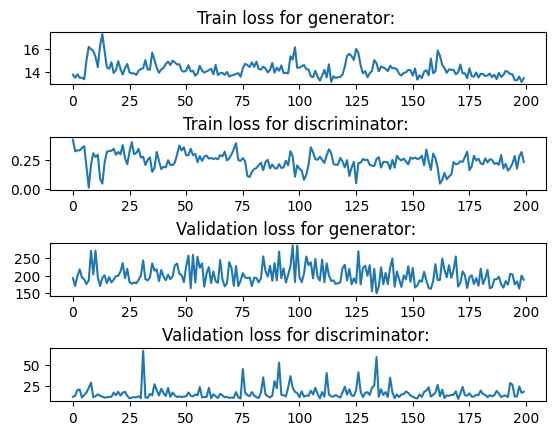

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchvision.utils import save_image
import matplotlib.pyplot as plt

torch.backends.cudnn.benchmark = True


def train_fn(
    disc, gen, loader, opt_disc, opt_gen, l1_loss, bce, g_scaler, d_scaler,typ, dataset_size
):
    if typ == "T":
        disc.train()
        gen.train()
    else:
        disc.eval()
        gen.eval()
    loop = tqdm(loader, leave=True)
    D_loss_mean = 0
    G_loss_mean = 0
    for idx, (x, y) in enumerate(loop):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
    
        # Train Discriminator
        if typ == "V":
            with torch.no_grad():
                    y_fake = gen(x)
                    D_real = disc(x, y)
                    D_real_loss = bce(D_real, torch.ones_like(D_real))
                    D_fake = disc(x, y_fake.detach())
                    D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))
                    D_loss = (D_real_loss + D_fake_loss) / 2
                    D_loss_mean += D_loss.item() * BATCH_SIZE
        else:
            with torch.cuda.amp.autocast():
                    y_fake = gen(x)
                    D_real = disc(x, y)
                    D_real_loss = bce(D_real, torch.ones_like(D_real))
                    D_fake = disc(x, y_fake.detach())
                    D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))
                    D_loss = (D_real_loss + D_fake_loss) / 2
                    D_loss_mean += D_loss.item() * BATCH_SIZE
        if typ == "T":
            disc.zero_grad()
            d_scaler.scale(D_loss).backward()
            d_scaler.step(opt_disc)
            d_scaler.update()

        # Train generator
        if typ == "V":
            with torch.no_grad():
                    D_fake = disc(x, y_fake)
                    G_fake_loss = bce(D_fake, torch.ones_like(D_fake))
                    L1 = l1_loss(y_fake, y) * L1_LAMBDA
                    G_loss = G_fake_loss + L1
                    G_loss_mean += G_loss.item() * BATCH_SIZE
        else:
            with torch.cuda.amp.autocast():
                    D_fake = disc(x, y_fake)
                    G_fake_loss = bce(D_fake, torch.ones_like(D_fake))
                    L1 = l1_loss(y_fake, y) * L1_LAMBDA
                    G_loss = G_fake_loss + L1
                    G_loss_mean += G_loss.item() * BATCH_SIZE
        
        if typ == "T":
            opt_gen.zero_grad()
            g_scaler.scale(G_loss).backward()
            g_scaler.step(opt_gen)
            g_scaler.update()

    
    G_loss = G_loss_mean/dataset_size
    D_loss = D_loss_mean/dataset_size
    if typ == "T":
        print("Train loss for generator: ", G_loss)
        print("Train loss for discriminator: ", D_loss)
        
    else:
        print("Validation loss for generator: ", G_loss)
        print("Validation loss for discriminator: ", D_loss)
    
    return G_loss, D_loss
        
def main():
    disc = Discriminator(in_channels=3).to(DEVICE)
    gen = Generator(in_channels=3, features=64).to(DEVICE)
    opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999),)
    opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
    BCE = nn.BCEWithLogitsLoss()
    L1_LOSS = nn.L1Loss()

    if LOAD_MODEL:
        load_checkpoint(
            CHECKPOINT_GEN, gen, opt_gen, LEARNING_RATE,
        )
        load_checkpoint(
            CHECKPOINT_DISC, disc, opt_disc, LEARNING_RATE,
        )

    train_dataset = MapDataset(root_dir=TRAIN_DIR)
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
    )
    g_scaler = torch.cuda.amp.GradScaler()
    d_scaler = torch.cuda.amp.GradScaler()
    val_dataset = MapDataset(root_dir=VAL_DIR)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
    
    G_train = []
    D_train = []
    G_val = []
    D_val = []
    for epoch in range(NUM_EPOCHS):
        G_train_loss, D_train_loss = train_fn(
            disc, gen, train_loader, opt_disc, opt_gen, L1_LOSS, BCE, g_scaler, d_scaler,"T", len(train_dataset)
        )
        G_train.append(G_train_loss)
        D_train.append(D_train_loss)
        G_val_loss, D_val_loss = train_fn(
            disc, gen, val_loader, opt_disc, opt_gen, L1_LOSS, BCE, g_scaler, d_scaler,"V", len(val_dataset)
        )
        G_val.append(G_val_loss)
        D_val.append(D_val_loss)

        if SAVE_MODEL and epoch % 5 == 0:
            save_checkpoint(gen, opt_gen, filename="gen.pth.tar")
            save_checkpoint(disc, opt_disc, filename="disc.pth.tar")

        save_some_examples(gen, val_loader, epoch, folder="/kaggle/working/")
    
    fig, axs = plt.subplots(4)
    axs[0].plot(G_train)
    axs[1].plot(D_train)
    axs[2].plot(G_val)
    axs[3].plot(D_val)
    
    axs[0].set_title("Train loss for generator: ")
    axs[1].set_title("Train loss for discriminator: ")
    axs[2].set_title("Validation loss for generator: ")
    axs[3].set_title("Validation loss for discriminator: ")
    
    plt.subplots_adjust(hspace=1)

if __name__ == "__main__":
    main()

In [12]:
#!zip -r file.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/y_gen_102.png (deflated 0%)
  adding: kaggle/working/input_173.png (deflated 0%)
  adding: kaggle/working/input_124.png (deflated 0%)
  adding: kaggle/working/input_120.png (deflated 0%)
  adding: kaggle/working/y_gen_69.png (deflated 1%)
  adding: kaggle/working/y_gen_131.png (deflated 0%)
  adding: kaggle/working/y_gen_13.png (deflated 0%)
  adding: kaggle/working/y_gen_103.png (deflated 0%)
  adding: kaggle/working/y_gen_113.png (deflated 0%)
  adding: kaggle/working/y_gen_83.png (deflated 0%)
  adding: kaggle/working/input_64.png (deflated 1%)
  adding: kaggle/working/y_gen_127.png (deflated 0%)
  adding: kaggle/working/input_87.png (deflated 0%)
  adding: kaggle/working/y_gen_104.png (deflated 0%)
  adding: kaggle/working/y_gen_61.png (deflated 0%)
  adding: kaggle/working/input_4.png (deflated 1%)
  adding: kaggle/working/input_153.png (deflated 1%)
  adding: kaggle/working/y_gen_124.png (deflated 0%)
  adding: kaggle

# **Testing the generator**

In [7]:
gen = Generator(in_channels=3, features=64).to(DEVICE)

In [8]:
import torch.optim as optim

In [9]:
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

In [10]:
load_checkpoint("/kaggle/input/models-final/gen.pth.tar", gen, opt_gen, LEARNING_RATE)

=> Loading checkpoint


In [13]:
train_dataset = MapDataset(root_dir=TRAIN_DIR)
train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
    )

In [11]:
val_dataset = MapDataset(root_dir=VAL_DIR)
val_loader = DataLoader(val_dataset, batch_size=5, shuffle=False)

In [12]:
save_some_examples(gen, val_loader, 500, folder="/kaggle/working/")